# EA 614 Análise de Sinais
## Exercício de Fixação de Conceitos (EFC) 4 – Amostragem

### Júlia Perassolli De Lázari
### RA: 200298

## Introdução
Conforme visto em sala de aula, o Teorema da Amostragem de Shannon-Nyquist fornece a taxa mínima com que um sinal de banda limitada deve ser amostrado de modo a permitir sua reconstrução. Nos casos em que taxas inferiores são utilizadas, surge o fenômeno denominado aliasing, comprometendo a reconstrução do sinal original.

Neste exercício, estudaremos este fenômeno no contexto de um sinal de áudio, assim como uma maneira de atenuá-lo.

## Item a

Após importar as bibliotecas e pacotes necessários, carregar o [áudio a ser utilizado no exercício](https://drive.google.com/file/d/1fuSNp7mAgJfELqAHMiQaiTMfy5-lJo2L/view?usp=sharing), que é um trecho da música "I want it all" da banda Queen.

A taxa de amostragem utilizada foi de 44,1kHz, taxa de amostragem tipicamente empregada em sinais de áudio.

In [ ]:
#@title Import libraries
import math
import numpy as np
import matplotlib.pyplot as plt 
from scipy import signal

#for audio
from IPython.display import Audio
from scipy.io import wavfile
import cffi
import librosa
import IPython.display as ipd

#reading files from drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
pip install pysoundfile

In [ ]:
#read audio file from drive
queen_original = drive.CreateFile({'id':'1fuSNp7mAgJfELqAHMiQaiTMfy5-lJo2L'})
queen_original.GetContentFile('queen.wav')

queen_original, fs = librosa.load('queen.wav',sr=44100)
ipd.Audio(queen_original,rate=fs)

## Item b

Gerar o espectro do sinal analisado (trecho da música "I want it all") utilizando a função [espectro.py](https://drive.google.com/file/d/14Hv-MzNJgznQm684ndvNUuf6iETMaPdc/view?usp=sharing) dada pelo enunciado. 

In [ ]:
#@title Spectrum function
def spectrum(y,title):

    #fourier transform
    Y = np.abs(np.fft.fft(y))
    #frequencies
    w = np.linspace(0,2*math.pi,Y.size)

    #graph of the spectrum
    plt.figure() 
    plt.plot(w,Y/np.max(Y))
    plt.title(f'Espectro do sinal analisado \n {title}',fontsize = 15)
    plt.xlabel('$\Omega$ [rad]', fontsize=10)
    plt.ylabel('|$Y(e^{j\Omega})$|', fontsize=10)
    plt.grid(True)
    plt.xlim((0,2*math.pi))
    plt.show()
    
    #return Y    

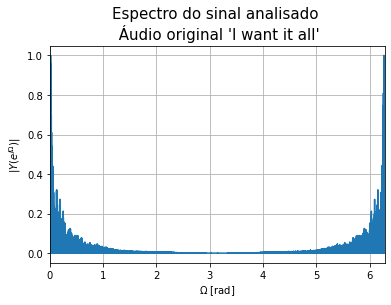

In [ ]:
#plot signal spectrum using the function defined above
spectrum(queen_original,"Áudio original 'I want it all'")

**Conclusão:** A partir do gráfico podemos observar que o espectro do sinal analisado é periódico e limitado em banda, concentrado em frequências baixas. Além disso, o espectro na região em torno de 3 rad é nulo, o que indica que não houve aliasing.

## Item c

Reduzir a taxa de amostragem por um fator de M = 6. Ou seja, a cada bloco de M amostras, uma foi retida e as outras M-1 descartadas. No caso, uma amostra foi retida e 5 descartadas, a cada bloco de 6 amostras. Esse processo é conhecido como decimação.

Temos que a relação matemática entre a sequência gerada e a sequência original é dada por: y<sub>dec</sub>(n) = y(Mn)

Para isso foi utilizado um loop para criar um vetor com uma taxa de amostragem 6 vezes menor (chamado de queen_sub).


In [ ]:
#create new vector for decimated audio
queen_sub = []

#append 1 in each 6 samples from original audio in the new vector
for i in range(len(queen_original)):
  if (i%6==0):
    queen_sub.append(queen_original[i])

O espectro do sinal decimado é então dado por:

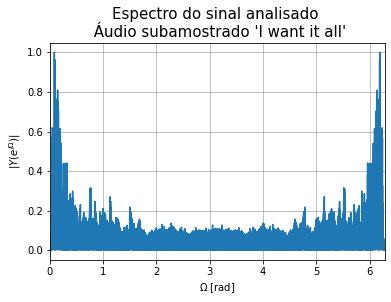

In [ ]:
spectrum(queen_sub,"Áudio subamostrado 'I want it all'")

**Conclusão:** percebe-se que o espectro do sinal subamostrado é semelhante ao do original e que a principal diferença é que ele deixou de ser nulo na região em torno de 3 rad. Isso ocorreu porque como a frequência de amostragem foi inferior ao dobro da frequência do sinal amostrado, houve aliasing. Ou seja, interferência entre frequências altas e baixas, o que resulta na distorção do sinal.

## Item d

Comparar o áudio do sinal original e do sinal subamostrado.

In [ ]:
#@title Original audio: 44,1kHz
ipd.Audio(queen_original,rate=fs)


In [ ]:
#@title Subsampled audio: 7,35kHz
fs2 = 7350
ipd.Audio(queen_sub,rate=fs2)


**Conclusão:** percebe-se que o áudio subamostrado tem uma qualidade bem pior, com alguns ruídos no fundo e uma sensação de eco. O ruído pode ser percebido principalmente quando há voz e também ocorreu distorção de frequências mais altas (mais agudas), o que é percebido principalmente no solo da guitarra.

## Item e

Uma maneira de minimizar o aliasing produzido pela subamostragem consiste em aplicar um filtro passa-baixas (FPB) sobre o sinal original antes da decimação. Para construir um FPB próximo ao ideal pode-se utilizar o método da janela de Kaiser.

A função [kaiser.py](https://drive.google.com/file/d/1xtAigsQTg5NmFaqQL1eShiweaAI3IdC1/view?usp=sharing) dada no enunciado recebe como parâmetros a frequência de passagem ($\Omega$<sub>p</sub>) e a frequência de rejeição ($\Omega$<sub>r</sub>), ambas em rad. A função retorna a resposta ao impulso do filtro.

A resposta ao impulso do filtro foi analisada para os seguintes casos:
- $\Omega$<sub>p</sub> = 0.45 rad, $\Omega$<sub>r</sub> = 2 rad;
- $\Omega$<sub>p</sub> = 0.45 rad, $\Omega$<sub>r</sub> = 0.5 rad;
- $\Omega$<sub>p</sub> = 1.5 rad, $\Omega$<sub>r</sub> = 2 rad.

In [ ]:
#@title Kaiser function
def kaiser(wp,wr):

    wc = (wp + wr)/2
    d = 0.01
    Ap = 20*math.log10((1+d)/(1-d))
    Ar = -20*math.log10(d)


    if Ar < 21:
        b = 0
        D = .9222

    elif Ar < 50:
        b = 0.5842*(Ar-21)**0.4+0.07886*(Ar-21)
        D = (Ar - 7.95)/14.36
    else:
        b = .1102*(Ar-8.7)
        D = (Ar - 7.95)/14.36

    k = math.ceil(math.pi*D/(wr-wp)-.5)
    M = 2*k+1

    n = np.arange(-k,k+1,1)
    
    w = np.i0(b*np.sqrt(1-(4/M**2)*n**2))
    w = np.divide(w,np.i0(b))

    h = wc/math.pi*np.sinc(wc*n/math.pi)*w

    return h

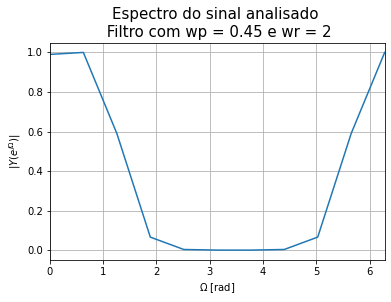

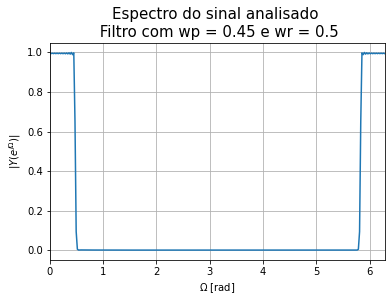

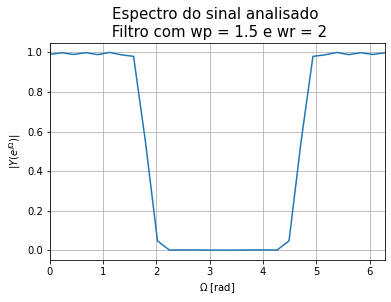

In [ ]:
#wp = 0.45 and wr = 2
h1 = kaiser(0.45,2)
spectrum(h1,"Filtro com wp = 0.45 e wr = 2")

#wp = 0.45 and wr = 0.5
h2 = kaiser(0.45,0.5)
spectrum(h2,"Filtro com wp = 0.45 e wr = 0.5")

#wp = 1.5 wr=2
h3 = kaiser(1.5,2.0)
spectrum(h3,"Filtro com wp = 1.5 e wr = 2")

**Conclusão:** analisando o espectro de todos os filtros é possível perceber que quando menor a diferença entre a frequência de passagem e a de rejeição, melhor o filtro. No caso, o segundo filtro é o que mais se aproxima de um FPB ideal.

Vale ressaltar que também quanto menor essa diferença mais complicada a construção e implementação do filtro.

## Item f

Utilizando $\Omega$<sub>p</sub> = 0.45 rad, $\Omega$<sub>r</sub> = 0.5 rad, filtrar através da convolução o sinal original.

In [ ]:
#convolution original signal(queen_original) and filter(h2)
queen_filter = signal.convolve(queen_original, h2)

O espectro do sinal filtrado pelo FPB escolhido é:

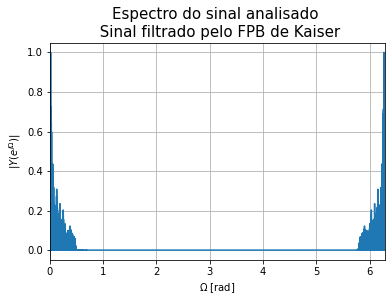

In [ ]:
spectrum(queen_filter,"Sinal filtrado pelo FPB de Kaiser")

**Conclusão:** percebe-se que o espectro se iguala a 0 para frequências maiores que 0.5, como esperado tendo em vista o espectro do filtro. Dessa forma, apenas as frequências mais significativas do sinal foram preservadas.

Comparando os áudios do sinal filtrado e do sinal original:

In [ ]:
#@title Original audio: 44,1kHz
ipd.Audio(queen_original,rate=fs)

In [ ]:
#@title Filtered signal: 44,1 kHz
ipd.Audio(queen_filter,rate=fs)

**Conclusão:** o áudio filtrado não apresenta ruídos e distorções e perde frequências mais agudas como esperado, fato que pode ser percebido principalmente no solo de guitarra. Além disso sua qualidade é um pouco inferior a do original, devido à perda dessas frequências.

## Item g

Subamostrar o sinal obtido no item (f) (ou seja, o sinal pré-filtrado pelo FPB de Kaiser) por um fator M = 6.

Comparar o espectro obtido com aquele associado ao sinal original subamostrado (item (c)).


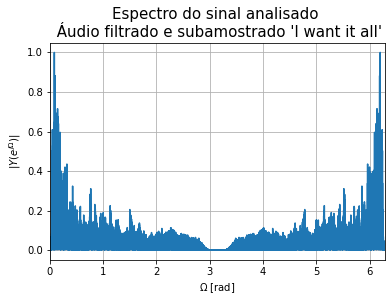

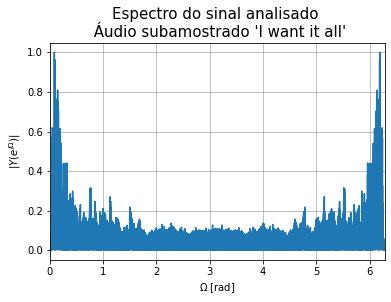

In [ ]:
#decimate filtered audio
queen_filter_sub = []
for i in range(len(queen_filter)):
  if (i%6==0):
    queen_filter_sub.append(queen_filter[i])

####spectrumns####
#filtered and subsampled signal
spectrum(queen_filter_sub,"Áudio filtrado e subamostrado 'I want it all'")

#subsampled signal (from item c)
spectrum(queen_sub,"Áudio subamostrado 'I want it all'")

**Conclusão:** os dois sinais são bem semelhantes, tendo como principal diferença o valor nulo em torno de 3 rad no sinal filtrado. Ou seja, para o sinal filtrado e então subamostrado não ocorre aliasing, enquanto para o que foi apenas subamostrado ocorre e portanto, distorções do áudio.

Comparando os áudios

In [ ]:
#@title Original audio: 44,1kHz
ipd.Audio(queen_original,rate=fs)


In [ ]:
#@title Subsampled audio: 7,35kHz
fs2 = 7350
ipd.Audio(queen_sub,rate=fs2)


In [ ]:
#@title Filtered and subsampled signal: 7,35kHz
ipd.Audio(queen_filter_sub,rate=fs2)

In [ ]:
#@title Filtered audio: 44,1kHz
ipd.Audio(queen_filter,rate=fs)